In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt

# Orden del archivo
1. Simulación pasivo
    1. Consideraciones
    2. Crear datos de clientes
    
2. Activos
    1. Improtar datos de mercado
    2. Usar Spline para contruir curva completa de UVR para el momento t
    3. Valoración del pasivo
    4. Simulación de activos 
   
3. Optimización de portafolio y frontera eficiente


# 1. Simulación pasivo 

## 1.1. Consideraciones 
1. Se hacen 1000 simulaciones de los flujos por año
2. Se crea un array de 5000 personas para cada edad de la tabla 
3. hace un muestreo del número de personas que se murieron en cada año 
4. luego voy haceindo un loop por fecha en el que verifique si se murio 
5. si se murió sigue muerto si no puede morir. L ohago por 99 años 
6. luego de las personas que quedan vivas multiplico el valor 
7. Luego trae a valor presente
8. Dependiendo de los años
9. En un año tenemos que saber las tasas a un año y el flujo. Entonces hacemos las simulaciones de los activos. 

In [2]:
mort=pd.read_excel("Mortalidad.xlsx", sheet_name= "Probs", index_col=0)
mort.tail()

,ProbH,ProbM
Edad,,
106,0.480306,0.478870
107,0.517895,0.517780
108,0.558952,0.557554
109,0.599010,0.599593
110,1.000000,1.000000


## 1.2. Crear base de clientes

In [3]:
''' En esta sección voy a crea una base que me represente el tipo de sexo y el número de personas por cada persona'''
grupo_por_ano=pd.DataFrame()


hombres=pd.DataFrame(np.ones(2500))
hombres['sexo']='H'
mujeres=pd.DataFrame(np.ones(2500))
mujeres['sexo']='M'


grupo_por_ano=hombres
grupo_por_ano=grupo_por_ano.append(mujeres,ignore_index=True)
grupo_por_ano.columns=['grupo','sexo']
grupo_por_ano

,grupo,sexo
0,1.0,H
1,1.0,H
2,1.0,H
3,1.0,H
4,1.0,H
...,...,...
4995,1.0,M
4996,1.0,M
4997,1.0,M
4998,1.0,M


In [4]:
'''Voy a crear el conjunto total de clientes, es decir los 200.000 mil clientes, 
de tal manera que se diferencien por sexo y por la edad'''

base_cliente=pd.DataFrame()
grupo=0
for i in range(50,90):
    grupo+=1
    grupo_por_ano['grupo']=grupo
    grupo_por_ano['edad']=i
    base_cliente=base_cliente.append(grupo_por_ano, ignore_index=True)

print(base_cliente.columns)
print('En total hay '+ str(base_cliente.sum()[0]))
base_cliente.groupby(['edad','sexo']).count()


Index(['grupo', 'sexo', 'edad'], dtype='object')
En total hay 4100000


grupo
edad sexo       
50   H      2500
     M      2500
51   H      2500
     M      2500
52   H      2500
...          ...
87   M      2500
88   H      2500
     M      2500
89   H      2500
     M      2500

[80 rows x 1 columns]

In [5]:
base_cliente

,grupo,sexo,edad
0,1,H,50
1,1,H,50
2,1,H,50
3,1,H,50
4,1,H,50
...,...,...,...
199995,40,M,89
199996,40,M,89
199997,40,M,89
199998,40,M,89


In [6]:
import time
'''
Si la persona está viva tiene el valor de 1, si muere tiene el valor de 0. 
Tengo 200 mil personas entre los 50 y los 89 años. Por cada grupo hay 2500 mujeres y 2500 hombres.

Ahora voy a hacer un muestre de las personas que se mueren de acá a 100 años.
'''
base_cliente['t0']=1
df=base_cliente
vida_simulada=base_cliente
simulacion={}

for i in range(1):
    start = time.time()
    edad_add=0
    for t in range(60):
        edad_add+=1
        #situacion inicial
        #print(t)
        try:
            df=df[df['t'+str(t)]==1]
            #print(len(df))
        except:
            print('Todo murieron')
            break
    # Voy a irle sumando cada año la edad para que cambien las probabilidades de los grupos     
    #df['edad']=df['edad']+edad_add
        df['t'+str(t+1)]=df['t'+str(t)]
        vida_simulada['t'+str(t+1)]=vida_simulada['t'+str(t)]
        for edad in range(50,90):
            df_m=df[df['edad']==edad]
        #len(df_m)
            muertes_h=df_m[df_m['sexo']=='H'].sample(frac=mort['ProbH'][min(110,edad+t)])
            muertes_m=df_m[df_m['sexo']=='M'].sample(frac=mort['ProbM'][min(110,edad+t)])
            muertos_t=muertes_h.append(muertes_m).index
            df.loc[muertos_t,'t'+str(t+1)]=0
            vida_simulada.loc[muertos_t,'t'+str(t+1)]=0

    end = time.time()
    print(end - start)
simulacion[i]=vida_simulada

26.117773056030273


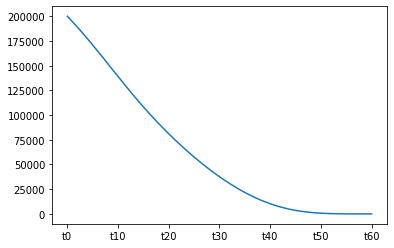

In [7]:
vida_simulada[vida_simulada.columns[3:]].sum(axis=0).plot()

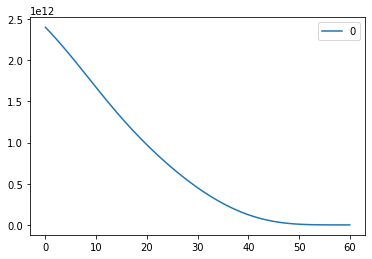

In [8]:
flujos=pd.DataFrame(vida_simulada[vida_simulada.columns[3:]].sum(axis=0)*1000000*12)
flujos=flujos.reset_index()
flujos.plot()

In [9]:
flujos

,index,0
0,t0,2400000000000
1,t1,2334648000000
2,t2,2266836000000
3,t3,2196744000000
4,t4,2124660000000
...,...,...
56,t56,336000000
57,t57,156000000
58,t58,60000000
59,t59,12000000


# 2. Activos

In [10]:
# importar los datos de mercado. 
'''
Modelar los diferentes activos: 

Descargar datos del banrep para TRM. 
1) se le hace la diferencia a las series
2) a las diferencias se normalizan 
3) les hace componentes principales a las diferencias normalizadas
4) luego se saca los componentes
5) se simulan los componentes seleccionados con el mejor módelo del punto 4


Todo volver las tasas a tasas reales, con fisher. 

Ya con los bonos simulados. Tengo que hacer la valoraciones de los bonos
es decir:
Pv=100/(1+tasa_t)^t

Para saber los valores intermedios usar interpolación lineal
'''

'\nModelar los diferentes activos: \n\nDescargar datos del banrep para TRM. \n1) se le hace la diferencia a las series\n2) a las diferencias se normalizan \n3) les hace componentes principales a las diferencias normalizadas\n4) luego se saca los componentes\n5) se simulan los componentes seleccionados con el mejor módelo del punto 4\n\n\nTodo volver las tasas a tasas reales, con fisher. \n\nYa con los bonos simulados. Tengo que hacer la valoraciones de los bonos\nes decir:\nPv=100/(1+tasa_t)^t\n\nPara saber los valores intermedios usar interpolación lineal\n'

In [11]:
'''
Debe tomar todo en los cambios y luego se debe normalizar
'''

'\nDebe tomar todo en los cambios y luego se debe normalizar\n'

## 2.1. Importar datos

In [12]:
tes=pd.read_excel('TES.xlsx',index_col=0)
uvr=pd.read_excel('UVR.xlsx',index_col=0)
corp=pd.read_excel('corp.xlsx',index_col=0)
index=pd.read_excel('index.xlsx',index_col=0)
ipc=pd.read_excel('ipc.xlsx',index_col=0)

In [49]:
tes=tes.dropna()
uvr=uvr.dropna()
corp=corp.dropna()
index=index.dropna()
ipc=ipc.dropna()


### 2.1.2. Importar datos de la TRM 

In [50]:
#usdcop.to_csv('usdcop.csv')
usdcop=pd.read_csv('usdcop.csv',index_col=0)
usdcop.columns=['usdcop']
usdcop

,usdcop
Date,
2016-02-03,3387.69
2016-02-04,3382.20
2016-02-05,3315.75
2016-02-08,3320.49
2016-02-09,3367.02
...,...
2020-04-14,3870.31
2020-04-15,3858.21
2020-04-16,3920.83


In [51]:
datos={
'tes':tes,
'uvr':uvr,
'corp':corp,
'index':index,
'usdcop':usdcop
}

In [52]:
base_simulacion=pd.DataFrame(index=tes.index)
for i in datos:
    base_simulacion=base_simulacion.join(datos[i])

In [53]:
base_simulacion=base_simulacion.dropna()
base_simulacion

,TES_6m,TES_1y,TES_3y,TES_5y,TES_10y,TES_15y,UVR_6m,UVR_1y,UVR_3y,UVR_5y,...,CORP_3m,CORP_6m,CORP_1y,CORP_3y,CORP_5y,CORP_10y,CORP_15y,COLCAP Index,SPX Index,usdcop
Dates,,,,,,,,,,,,,,,,,,,,,
2016-02-03,6.356,6.618,7.579,8.211,8.988,9.501,0.7375,1.3603,3.0161,3.8494,...,0.788,0.852,0.977,1.771,2.305,3.230,3.953,1180.66,1912.53,3387.69
2016-02-04,6.362,6.624,7.559,8.189,8.975,9.470,0.7247,1.3425,3.0165,3.8796,...,0.790,0.854,0.979,1.769,2.295,3.234,3.958,1188.73,1915.45,3382.20
2016-02-05,6.349,6.622,7.580,8.182,8.956,9.457,0.7262,1.3445,3.0172,3.8779,...,0.790,0.858,0.991,1.783,2.305,3.235,3.952,1195.11,1880.05,3315.75
2016-02-08,6.382,6.662,7.673,8.248,9.000,9.508,0.6940,1.2941,2.9725,3.8783,...,0.795,0.857,0.978,1.730,2.226,3.130,3.850,1192.98,1853.44,3320.49
2016-02-09,6.411,6.700,7.738,8.313,9.079,9.568,0.7345,1.3616,3.0657,3.9448,...,0.813,0.876,0.998,1.740,2.229,3.118,3.823,1196.90,1852.21,3367.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07,4.663,4.733,5.050,5.426,6.276,6.624,0.7404,0.8621,1.3445,1.7634,...,1.878,1.857,1.833,1.898,2.106,2.627,3.030,1663.83,3237.18,3262.05
2020-01-08,4.610,4.677,4.982,5.365,6.210,6.535,0.7325,0.8513,1.3255,1.7411,...,1.895,1.875,1.855,1.921,2.128,2.654,3.059,1656.96,3253.05,3264.26
2020-01-09,4.641,4.697,4.963,5.305,6.142,6.257,0.8061,0.9141,1.3515,1.7441,...,1.894,1.875,1.854,1.917,2.119,2.635,3.038,1653.54,3274.70,3254.42


In [54]:
base_simulación=ipc.resample('M').last().join(base_simulacion.resample('M').last())
base_simulación=base_simulación.dropna()
base_simulación

,IPC,TES_6m,TES_1y,TES_3y,TES_5y,TES_10y,TES_15y,UVR_6m,UVR_1y,UVR_3y,...,CORP_3m,CORP_6m,CORP_1y,CORP_3y,CORP_5y,CORP_10y,CORP_15y,COLCAP Index,SPX Index,usdcop
Fecha,,,,,,,,,,,,,,,,,,,,,
2016-02-29,90.329820,6.495,6.783,7.746,8.295,8.967,9.325,0.6206,1.1714,2.8048,...,0.803,0.890,1.055,1.801,2.264,3.095,3.829,1244.17,1932.23,3306.00
2016-03-31,91.182240,6.764,6.902,7.267,7.625,8.154,8.501,1.5325,1.9936,3.1256,...,0.689,0.768,0.918,1.601,2.058,2.934,3.669,1336.27,2059.74,3022.35
2016-04-30,91.634600,6.661,6.767,7.352,7.723,8.146,8.560,1.5226,1.9083,2.9040,...,0.674,0.750,0.890,1.543,2.001,2.859,3.589,1342.42,2065.30,2885.72
2016-05-31,92.101740,6.050,6.195,7.065,7.568,8.063,8.412,1.8787,2.1525,2.9462,...,0.772,0.854,1.005,1.655,2.093,2.904,3.652,1292.51,2096.96,3069.17
2016-06-30,92.543520,5.684,5.815,6.477,6.981,7.525,7.866,1.8107,2.1084,2.8795,...,0.735,0.798,0.910,1.406,1.798,2.612,3.363,1313.18,2098.86,2916.15
2016-07-31,93.024730,6.128,6.262,6.828,7.210,7.612,7.953,1.9629,2.1840,2.8615,...,0.768,0.829,0.937,1.383,1.736,2.518,3.245,1308.22,2173.60,3091.78
2016-08-31,92.727130,6.099,6.221,6.769,7.128,7.480,7.823,2.1585,2.5205,3.2816,...,0.847,0.913,1.037,1.486,1.842,2.593,3.296,1380.18,2170.95,2933.82
2016-09-30,92.678140,5.537,5.681,6.243,6.622,7.002,7.395,3.5957,3.5156,3.3070,...,0.960,1.018,1.125,1.526,1.865,2.648,3.368,1338.83,2168.27,2879.95
2016-10-31,92.622630,5.724,5.839,6.392,6.820,7.338,7.759,2.2981,2.3974,2.7272,...,0.940,1.012,1.148,1.646,2.032,2.848,3.560,1365.53,2126.15,2967.66


In [55]:
diff_base_simulacion=base_simulación.diff().dropna()
diff_base_simulacion

,IPC,TES_6m,TES_1y,TES_3y,TES_5y,TES_10y,TES_15y,UVR_6m,UVR_1y,UVR_3y,...,CORP_3m,CORP_6m,CORP_1y,CORP_3y,CORP_5y,CORP_10y,CORP_15y,COLCAP Index,SPX Index,usdcop
Fecha,,,,,,,,,,,,,,,,,,,,,
2016-03-31,0.852420,0.269,0.119,-0.479,-0.670,-0.813,-0.824,0.9119,0.8222,0.3208,...,-0.114,-0.122,-0.137,-0.200,-0.206,-0.161,-0.160,92.10,127.51,-283.65
2016-04-30,0.452360,-0.103,-0.135,0.085,0.098,-0.008,0.059,-0.0099,-0.0853,-0.2216,...,-0.015,-0.018,-0.028,-0.058,-0.057,-0.075,-0.080,6.15,5.56,-136.63
2016-05-31,0.467140,-0.611,-0.572,-0.287,-0.155,-0.083,-0.148,0.3561,0.2442,0.0422,...,0.098,0.104,0.115,0.112,0.092,0.045,0.063,-49.91,31.66,183.45
2016-06-30,0.441780,-0.366,-0.380,-0.588,-0.587,-0.538,-0.546,-0.0680,-0.0441,-0.0667,...,-0.037,-0.056,-0.095,-0.249,-0.295,-0.292,-0.289,20.67,1.90,-153.02
2016-07-31,0.481210,0.444,0.447,0.351,0.229,0.087,0.087,0.1522,0.0756,-0.0180,...,0.033,0.031,0.027,-0.023,-0.062,-0.094,-0.118,-4.96,74.74,175.63
2016-08-31,-0.297600,-0.029,-0.041,-0.059,-0.082,-0.132,-0.130,0.1956,0.3365,0.4201,...,0.079,0.084,0.100,0.103,0.106,0.075,0.051,71.96,-2.65,-157.96
2016-09-30,-0.048990,-0.562,-0.540,-0.526,-0.506,-0.478,-0.428,1.4372,0.9951,0.0254,...,0.113,0.105,0.088,0.040,0.023,0.055,0.072,-41.35,-2.68,-53.87
2016-10-31,-0.055510,0.187,0.158,0.149,0.198,0.336,0.364,-1.2976,-1.1182,-0.5798,...,-0.020,-0.006,0.023,0.120,0.167,0.200,0.192,26.70,-42.12,87.71
2016-11-30,0.103680,0.143,0.084,0.026,0.099,0.030,0.087,-0.4555,-0.3208,0.0586,...,0.132,0.158,0.209,0.422,0.534,0.539,0.486,-79.46,72.66,197.43


In [56]:
'''Normalizar la base de datos usando (x-u)/sigma'''
from sklearn import preprocessing
x = pd.DataFrame(preprocessing.StandardScaler().fit_transform(diff_base_simulacion),columns=diff_base_simulacion.columns)

In [57]:
x.tail()

,IPC,TES_6m,TES_1y,TES_3y,TES_5y,TES_10y,TES_15y,UVR_6m,UVR_1y,UVR_3y,...,CORP_3m,CORP_6m,CORP_1y,CORP_3y,CORP_5y,CORP_10y,CORP_15y,COLCAP Index,SPX Index,usdcop
41,-0.745293,0.434994,0.541035,0.892565,0.661771,0.642873,0.624879,0.451411,0.353627,0.293570,...,-2.116939,-2.253166,-2.408834,-2.240463,-2.177273,-2.443746,-2.645053,-0.221585,-0.908832,1.458972
42,-0.202734,-0.030348,-0.077120,-0.214435,-0.149769,-0.003160,-0.032358,-0.817733,-0.704918,-0.502210,...,-0.468593,-0.370981,-0.163389,0.395745,0.652157,1.059102,1.014173,0.176997,0.246852,-0.016371
43,-0.472431,0.205958,0.375669,0.775565,0.683586,0.166424,-0.005295,0.409009,0.218510,-0.106206,...,-1.935802,-1.849841,-1.637756,-0.817435,-0.538864,-0.280223,0.013900,0.872858,0.363752,-0.625264
44,-0.453423,0.420452,0.698527,1.954565,2.031789,2.233729,2.318230,-0.036120,0.189645,0.994119,...,0.101988,0.175749,0.328067,0.474437,0.434508,0.343987,0.178502,-0.574154,0.836229,0.985998
45,-0.679356,-0.179403,-0.317294,-0.920935,-0.620985,-0.423081,-0.326181,-1.089734,-1.155559,-1.172116,...,-0.722185,-0.738456,-0.731105,-0.378067,-0.139842,0.168239,0.210156,0.784053,0.579916,-1.816405


## 2.2.  Interpolación de la UVR

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy

In [59]:
curva_t=uvr[:1].reset_index().T[1:].reset_index()
curva_t['año']=pd.DataFrame([1/2,1,3,5,10,15])
#curva_t=curva_t.set_index(curva_t['año'])
curva_t

,index,0,año
0,UVR_6m,0.3702,0.5
1,UVR_1y,0.7073,1.0
2,UVR_3y,1.7818,3.0
3,UVR_5y,2.5265,5.0
4,UVR_10y,3.5615,10.0
5,UVR_15y,4.0248,15.0


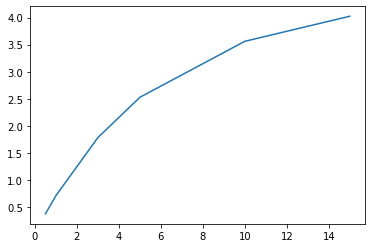

In [62]:
x_data = curva_t.año.values
y_data = uvr[:1].reset_index().T[1:].values
plt.plot(x_data, y_data)

In [63]:
tck = interpolate.splrep(x_data, y_data, s=0)
xnew = np.array(range(1,16))
ynew = interpolate.splev(xnew, tck, der=0)

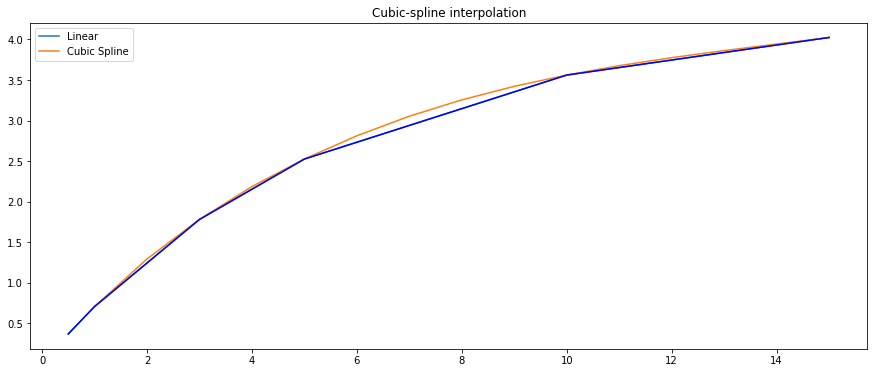

In [65]:
plt.figure(figsize=(15,6))
plt.plot(x_data, y_data, xnew, ynew, x_data, y_data, 'b')
plt.legend(['Linear', 'Cubic Spline'])
plt.title('Cubic-spline interpolation')
plt.show()

# Valoración del pasivo 

In [66]:
'''
Si se mantiene el valor en 1.000.000 durante todas las fechas, tenemos que traer
a valor presente con la UVR. 

(1+r_nomila)=(1+real)*(1+inflación)

'''
def valoracion(df):
    df['DF']=(1+df.rate/100)**(-1*flujos.index)
    df['VP']=(df[0]*df['DF'])
    return df

flujos['rate']=pd.DataFrame(ynew,index=xnew)
flujos=flujos.ffill()
flujos=flujos.fillna(0)
flujos=valoracion(flujos)
flujos

,index,0,rate,DF,VP
0,t0,2400000000000,0.000000,1.000000,2.400000e+12
1,t1,2334648000000,0.707300,0.992977,2.318251e+12
2,t2,2266836000000,1.294593,0.974602,2.209264e+12
3,t3,2196744000000,1.781800,0.948396,2.083383e+12
4,t4,2124660000000,2.187211,0.917094,1.948513e+12
...,...,...,...,...,...
56,t56,336000000,4.024800,0.109732,3.687003e+07
57,t57,156000000,4.024800,0.105487,1.645591e+07
58,t58,60000000,4.024800,0.101405,6.084315e+06
59,t59,12000000,4.024800,0.097482,1.169782e+06


In [90]:
print('Valor pasivo hoy: '+str(flujos['VP'].sum()),
      'Valor pasivo en un año: '+str(flujos['VP'][1:].sum()),
      flujos['VP'][1:].sum()/flujos['VP'].sum()-1)

Valor pasivo hoy: 30290867919413.652 Valor pasivo en un año: 27890867919413.652 -0.07923180036917399


# Simulación

In [91]:
import scipy.linalg as la
import numpy as np
def componentes(df):
    varcov=df.cov()
    vals = pd.DataFrame(la.eig(varcov)[0])
    porcentaje=vals/vals.sum()
    cum_perct=porcentaje.cumsum()
    SQRTvals= pd.DataFrame(vals.apply(mt.sqrt, axis= 1))
    vecs = pd.DataFrame(la.eig(varcov)[1])
    return vals, vecs, SQRTvals, cum_perct

In [92]:
comp_=componentes(x)[1] 
comp_

/Users/armandomejiagarces/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  return converter(self.iloc[0])


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.091687,-0.037403,0.040217,-0.001297,-0.194657,-0.731031,-0.584918,0.086637,-0.119488,0.018773,...,-0.018307,-0.020945,0.001079,-0.015672,0.013658,0.013291,-0.003148,-0.004504,0.000697,0.000084
1,-0.009527,0.278262,-0.356422,-0.246986,-0.153437,-0.225268,0.201018,0.174659,0.105721,-0.091108,...,0.096392,0.099555,-0.153207,-0.018402,-0.588530,0.064486,-0.179074,0.179228,0.027037,-0.061802
2,-0.038227,0.307247,-0.339316,-0.235090,-0.134335,-0.214400,0.201034,0.130653,0.118842,-0.058431,...,0.024986,-0.107129,0.055393,0.088630,0.658624,-0.072385,0.199736,-0.188902,-0.028812,0.064769
3,-0.203596,0.366034,-0.093510,-0.031423,-0.072022,-0.072155,0.050637,-0.064941,-0.055978,0.087722,...,-0.092685,-0.158727,0.477794,-0.206662,-0.166862,-0.001138,-0.031587,0.014295,-0.000763,-0.001527
4,-0.244305,0.336064,-0.014845,0.023376,-0.047322,0.040556,-0.061861,-0.107521,-0.142991,0.043015,...,-0.056503,0.366353,-0.648893,0.261717,0.092947,0.010222,0.013766,0.029079,0.006140,-0.012781
5,-0.245473,0.304909,-0.038314,0.015806,0.015464,0.137469,-0.137609,-0.250337,-0.151431,0.127258,...,-0.402536,-0.453159,-0.198723,-0.330681,-0.021116,-0.078052,0.000520,0.018385,0.007886,0.001840
6,-0.258659,0.283416,-0.006360,-0.003117,0.020229,0.113446,-0.115984,-0.249765,-0.207628,0.088822,...,0.520883,0.242664,0.381900,0.188756,-0.000358,0.066755,-0.010376,-0.039166,-0.009052,0.007462
7,0.159334,-0.014367,0.102570,-0.536577,-0.057806,0.207817,-0.233770,-0.065346,-0.152229,-0.050242,...,0.254542,-0.129986,-0.137048,-0.154897,0.092822,-0.010810,-0.489173,-0.148340,-0.038980,0.336822
8,0.147672,-0.009330,0.155740,-0.549828,-0.100900,0.171211,-0.141053,-0.042305,-0.123522,-0.004595,...,0.036243,-0.041866,0.003306,0.025493,-0.076164,-0.091747,0.501594,0.118842,0.065264,-0.532489
9,-0.004627,0.044105,0.430387,-0.333490,-0.195074,-0.078351,0.311692,0.110963,0.050688,0.196786,...,-0.317860,0.167638,0.120545,0.103172,-0.040104,0.095059,0.120138,0.159169,-0.051641,0.456473


In [93]:
componentes(x)[3]

/Users/armandomejiagarces/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  return converter(self.iloc[0])


,0
0,0.354483+0.000000j
1,0.530610+0.000000j
2,0.659037+0.000000j
3,0.756299+0.000000j
4,0.835635+0.000000j
5,0.881663+0.000000j
6,0.915357+0.000000j
7,0.942917+0.000000j
8,0.962596+0.000000j
9,0.979677+0.000000j


In [94]:
componentes={}
for componente in range(0,8):
    componentes[componente+1]=np.dot(x,comp_[comp_.columns[componente]])


In [95]:
componentes

{1: array([ 7.41553422,  1.04724483, -1.2201498 ,  5.68767952, -1.24052199,
        -0.89299107,  2.15651516, -3.21354955, -6.83950297, -0.87580619,
         1.41685241, -0.15228448, -0.7483954 ,  2.40952369,  2.91794123,
        -2.45923653, -1.34192655,  0.70199639, -0.97445715, -1.50054228,
        -1.22471912, -1.40245409, -2.59565703, -5.13984649, -1.32841561,
        -0.03810461, -1.26975737, -1.77031994, -1.14858612,  0.14209688,
        -2.67763324, -5.06052101, -0.32685676,  2.25885243,  3.86568586,
        -0.20429232,  4.0284226 , -1.13852268,  3.00340377,  6.25357956,
         0.90615233,  3.26568352, -0.36415314,  1.51422794, -3.48013682,
         1.63794796]),
 2: array([-2.0881742 ,  0.47584405, -2.38730635, -2.30208718,  3.25944419,
        -0.98228814, -4.73848768,  1.44094195, -1.54203871, -1.96043117,
        -0.50486688,  1.30479834, -3.01045429, -1.40343658,  1.28222571,
         0.39335989,  3.42713216, -0.46208599, -1.52422832, -0.12889917,
        -3.51558105, -

In [112]:
#!pip install pmdarima
'''Ahora voy a crear el auto arima para cada uno de los componentes, voy a crear un diccionario 
donde guarde los resultados del modelo y otro donde guarde el orden del model'''

'Ahora voy a crear el auto arima para cada uno de los componentes, voy a crear un diccionario \ndonde guarde los resultados del modelo y otro donde guarde el orden del model'

In [105]:
import pmdarima as pm
from pmdarima.arima import auto_arima

resultados={}
orden_model={}
for i in componentes:
    model = pm.auto_arima(componentes[i], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    orden_model[i]=model.order
    resultados[i]=model

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=231.990, BIC=239.217, Time=0.054 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=244.154, BIC=247.767, Time=0.009 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=239.258, BIC=244.678, Time=0.024 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=230.128, BIC=235.548, Time=0.033 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=242.215, BIC=244.022, Time=0.009 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=231.876, BIC=239.103, Time=0.035 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=230.328, BIC=239.361, Time=0.195 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.369 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AI

# Simulación

In [111]:
dst = Distribution()

dist = getattr(scipy.stats, 't')
param=dst.Random()[1]
sim=dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=52)

NameError: name 'Distribution' is not defined

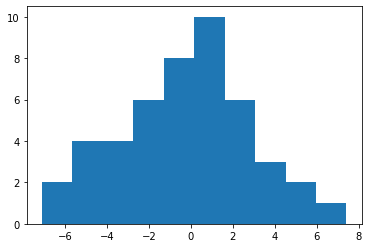

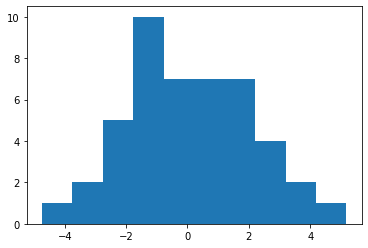

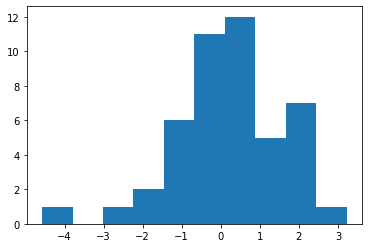

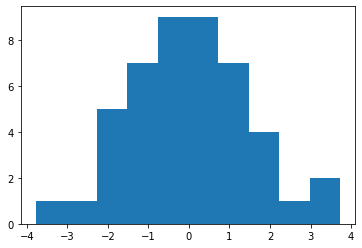

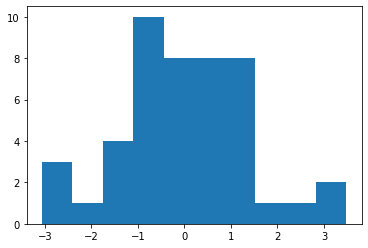

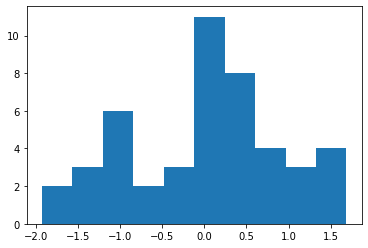

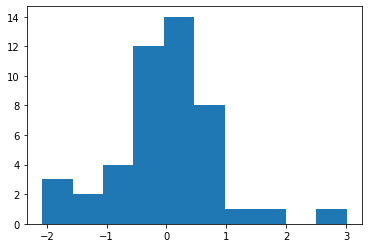

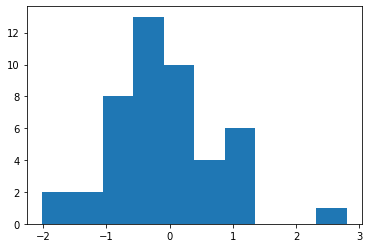

In [117]:
import statsmodels.api as sm
import scipy
import scipy.stats

dist = getattr(scipy.stats, 't') 

simulacion_componente={}

for i in componentes:
    model2=sm.tsa.statespace.SARIMAX(endog=componentes[i],order=orden_model[i],enforce_invertibility=False)
    results=model2.fit()
    plt.hist(results.resid)
    plt.show()
    #param=dst.Random()[1]
    #for i in range(1000):
    #    dist = getattr(scipy.stats, 't')
    #    sim=dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=52)
    #    simulaciones_1[i]=results.simulate(nsimulations=12)


In [99]:
for modelo in resultados:
    print(resultados[modelo].order)

(0, 1, 1)
(0, 0, 0)
(0, 0, 2)
(0, 0, 0)
(0, 0, 0)
(0, 0, 1)
(0, 0, 0)
(0, 1, 1)


(0, 1, 1)